In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [67]:
data = pd.read_excel("orbits-for-near-earth-asteroids-neas.xlsx")
data.head()

,Last observation,"r.m.s. residual ("")",Argument of perihelion,Other designations,Tp,Orbit type,NEO flag,One km NEO flag,Epoch of the orbit (Julian Date),Reference,...,Inclination to the ecliptic,Perihelion distance (AU),Number,"Mean daily motion, n (degrees/day)",Semilatus rectum distance (AU),Hex flags,Computer,Synodic period (years),Aphelion distance (AU),Principal designation
0,2023-11-04,0.54,178.90779,1956 PC,2.460446e+06,Amor,1.0,1.0,2460200.5,E2023-V42,...,10.82793,1.133254,(433),0.559777,0.692869,1804,MPCLINUX,2.314555,1.782981,A898 PA
1,2022-08-05,0.57,156.23022,2000 JW8,2.459956e+06,Amor,1.0,1.0,2460200.5,E2023-V08,...,11.57585,1.194321,(719),0.230242,0.923801,1804,MPCLINUX,1.304809,4.078500,A911 TB
2,2023-10-11,0.83,26.64832,NaN,2.459867e+06,Amor,1.0,1.0,2460200.5,E2023-TI3,...,11.88205,1.082993,(1221),0.370736,0.777411,1804,MPCLINUX,1.602948,2.755167,1932 EA1
3,2023-07-15,0.60,31.43790,NaN,2.460009e+06,Apollo,1.0,1.0,2460200.5,E2023-P11,...,22.80103,0.186626,(1566),0.880499,0.170473,9803,MPCLINUX,9.377001,1.969530,1949 MA
4,2023-11-04,0.70,159.58873,NaN,2.460736e+06,Amor,1.0,1.0,2460200.5,E2023-V42,...,52.14655,1.127241,(1580),0.302558,0.838124,1804,MPCLINUX,1.442951,3.267777,1950 KA


Splitting the dataset into training and testing data

In [68]:
training_data, testing_data = train_test_split(data, test_size=0.25, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 25051
No. of testing examples: 8351


## Exploratory Data Analysis (EDA)

In [69]:
def extract_neo_data(data_frame):
    neo_data = data_frame[data_frame['NEO flag'] == 1.0]
    neo_data.to_csv('neo.csv')
    return neo_data

In [70]:
neo = extract_neo_data(data)

In [71]:
neo.isnull().any()

Last observation                      False
r.m.s. residual (")                   False
Argument of perihelion                False
Other designations                     True
Tp                                    False
Orbit type                            False
NEO flag                              False
One km NEO flag                        True
Epoch of the orbit (Julian Date)      False
Reference                             False
Node                                  False
Slope parameter, G                     True
Name                                   True
Perturbers 2                           True
Absolute magnitude, H                  True
Mean anomaly, M                       False
Number of oppositions                 False
Perturbers                             True
Orbital period (years)                False
Uncertainty parameter                  True
Number of observations                False
Arc years                              True
Semimajor axis, a (AU)          

In [72]:
neo = neo.drop(['Last observation'], axis=1)

In [73]:
neo['NEO flag'] = neo['NEO flag'].fillna(0)

In [74]:
neo['One km NEO flag'] =  neo['One km NEO flag'].fillna(0)

In [75]:
neo['Absolute magnitude, H'].isnull().sum()

3

In [76]:
neo.isnull().any()

r.m.s. residual (")                   False
Argument of perihelion                False
Other designations                     True
Tp                                    False
Orbit type                            False
NEO flag                              False
One km NEO flag                       False
Epoch of the orbit (Julian Date)      False
Reference                             False
Node                                  False
Slope parameter, G                     True
Name                                   True
Perturbers 2                           True
Absolute magnitude, H                  True
Mean anomaly, M                       False
Number of oppositions                 False
Perturbers                             True
Orbital period (years)                False
Uncertainty parameter                  True
Number of observations                False
Arc years                              True
Semimajor axis, a (AU)                False
Orbital eccentricity, e         

In [77]:
neo = neo.reset_index(drop=True)

In [78]:
from scipy.optimize import minimize

def moid(row):
    G = row['Slope parameter, G']
    a_p = np.radians(row['Argument of perihelion'])
    H = row['Absolute magnitude, H']
    q = row['Semilatus rectum distance (AU)']
    n = np.radians(row['Mean daily motion, n (degrees/day)'])
    Q = row['Aphelion distance (AU)']
    e = row['Orbital eccentricity, e']

    def relative_distance(theta):
        r = q * (1 + e) / (1 + e * np.cos(theta))
        return r

    def distance_between_orbits(theta):
        r_asteroid = relative_distance(theta)
        r_earth = Q / (1 + e * np.cos(theta - a_p))

        return np.abs(r_earth - r_asteroid)

    result = minimize(distance_between_orbits, 0)
    min_distance = distance_between_orbits(result.x)

    return float(min_distance)

    
neo['MOID'] = neo.apply(moid, axis=1)

neo.head()


,"r.m.s. residual ("")",Argument of perihelion,Other designations,Tp,Orbit type,NEO flag,One km NEO flag,Epoch of the orbit (Julian Date),Reference,Node,...,Perihelion distance (AU),Number,"Mean daily motion, n (degrees/day)",Semilatus rectum distance (AU),Hex flags,Computer,Synodic period (years),Aphelion distance (AU),Principal designation,MOID
0,0.54,178.90779,1956 PC,2.460446e+06,Amor,1.0,1.0,2460200.5,E2023-V42,304.28598,...,1.133254,(433),0.559777,0.692869,1804,MPCLINUX,2.314555,1.782981,A898 PA,3.680317e-01
1,0.57,156.23022,2000 JW8,2.459956e+06,Amor,1.0,1.0,2460200.5,E2023-V08,183.85389,...,1.194321,(719),0.230242,0.923801,1804,MPCLINUX,1.304809,4.078500,A911 TB,1.189120e-08
2,0.83,26.64832,NaN,2.459867e+06,Amor,1.0,1.0,2460200.5,E2023-TI3,171.31940,...,1.082993,(1221),0.370736,0.777411,1804,MPCLINUX,1.602948,2.755167,1932 EA1,1.095690e+00
3,0.60,31.43790,NaN,2.460009e+06,Apollo,1.0,1.0,2460200.5,E2023-P11,87.95271,...,0.186626,(1566),0.880499,0.170473,9803,MPCLINUX,9.377001,1.969530,1949 MA,8.927135e-01
4,0.70,159.58873,NaN,2.460736e+06,Amor,1.0,1.0,2460200.5,E2023-V42,62.23069,...,1.127241,(1580),0.302558,0.838124,1804,MPCLINUX,1.442951,3.267777,1950 KA,3.588154e-09


In [79]:
neo['PHA'] = np.where((neo['Absolute magnitude, H'] >= 22) & (neo['MOID'] <= 0.05), 1, 0)

In [80]:
def extract_pha_data(data_frame):
    pha_data = data_frame[data_frame['PHA'] == 'Y']
    pha_data.to_csv('pha.csv')
    return pha_data

In [81]:
def extract_neo_pha_data(data_frame):
    neo_pha_data = data_frame[(data_frame['PHA'] == 'Y') & (data_frame['NEO flag'] == 'Y')]
    neo_pha_data.to_csv('neo_pha.csv')
    return neo_pha_data


In [82]:
neo.describe()

,"r.m.s. residual ("")",Argument of perihelion,Tp,NEO flag,One km NEO flag,Epoch of the orbit (Julian Date),Node,"Slope parameter, G","Absolute magnitude, H","Mean anomaly, M",...,"Semimajor axis, a (AU)","Orbital eccentricity, e",Inclination to the ecliptic,Perihelion distance (AU),"Mean daily motion, n (degrees/day)",Semilatus rectum distance (AU),Synodic period (years),Aphelion distance (AU),MOID,PHA
count,33351.000000,33351.000000,3.335100e+04,33351.0,33351.000000,3.335100e+04,33351.000000,33348.000000,33348.000000,33351.000000,...,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000,3.335100e+04,33351.000000
mean,0.528970,182.599326,2.460185e+06,1.0,0.041258,2.460194e+06,172.130514,0.149979,23.441543,178.042332,...,1.763143,0.437671,12.055180,0.915156,0.525355,0.650506,5.642162,2.611130,5.825701e-01,0.101736
std,0.227248,104.263415,3.315028e+02,0.0,0.198890,1.723436e+02,103.742514,0.001697,2.990552,104.615752,...,1.874873,0.176736,10.722200,0.225452,0.282644,0.162290,205.643621,3.729409,9.667485e-01,0.302305
min,0.010000,0.010290,2.451481e+06,1.0,0.000000,2.451840e+06,0.002790,0.000000,9.260000,0.005530,...,0.461711,0.002356,0.006070,0.070462,0.000189,0.069099,0.457152,0.653767,7.744250e-11,0.000000
25%,0.350000,93.288435,2.460016e+06,1.0,0.000000,2.460200e+06,80.881120,0.150000,21.280000,87.266665,...,1.296789,0.305382,4.436955,0.791967,0.307089,0.543733,1.450778,1.674874,1.760351e-01,0.000000
50%,0.500000,184.606320,2.460193e+06,1.0,0.000000,2.460200e+06,171.942990,0.150000,23.760000,176.235920,...,1.695853,0.451947,8.516420,0.963396,0.446295,0.660444,1.815976,2.443347,4.380254e-01,0.000000
75%,0.700000,272.601320,2.460367e+06,1.0,0.000000,2.460200e+06,252.633190,0.150000,25.590000,267.790300,...,2.175838,0.564722,16.911535,1.061488,0.667421,0.768309,2.927335,3.358525,8.051747e-01,0.000000
max,4.390000,359.997940,2.461463e+06,1.0,1.000000,2.460200e+06,359.965340,0.150000,99.990000,359.998910,...,300.763322,0.995837,165.569480,1.299984,3.141582,1.249472,37244.781193,600.274566,9.984212e+01,1.000000


In [83]:
neo.to_excel("demo.xlsx")

In [84]:
imp_parameters = ['Slope parameter, G', 'Argument of perihelion', 'Absolute magnitude, H', 'Semilatus rectum distance (AU)', 'Mean daily motion, n (degrees/day)','Aphelion distance (AU)', 'PHA', 'Mean anomaly, M', 'Orbital eccentricity, e', 'MOID']

In [85]:
new_data = pd.read_excel("demo.xlsx")
new_data.head()

,Unnamed: 0,"r.m.s. residual ("")",Argument of perihelion,Other designations,Tp,Orbit type,NEO flag,One km NEO flag,Epoch of the orbit (Julian Date),Reference,...,Number,"Mean daily motion, n (degrees/day)",Semilatus rectum distance (AU),Hex flags,Computer,Synodic period (years),Aphelion distance (AU),Principal designation,MOID,PHA
0,0,0.54,178.90779,1956 PC,2.460446e+06,Amor,1,1,2460200.5,E2023-V42,...,(433),0.559777,0.692869,1804,MPCLINUX,2.314555,1.782981,A898 PA,3.680317e-01,0
1,1,0.57,156.23022,2000 JW8,2.459956e+06,Amor,1,1,2460200.5,E2023-V08,...,(719),0.230242,0.923801,1804,MPCLINUX,1.304809,4.078500,A911 TB,1.189120e-08,0
2,2,0.83,26.64832,NaN,2.459867e+06,Amor,1,1,2460200.5,E2023-TI3,...,(1221),0.370736,0.777411,1804,MPCLINUX,1.602948,2.755167,1932 EA1,1.095690e+00,0
3,3,0.60,31.43790,NaN,2.460009e+06,Apollo,1,1,2460200.5,E2023-P11,...,(1566),0.880499,0.170473,9803,MPCLINUX,9.377001,1.969530,1949 MA,8.927135e-01,0
4,4,0.70,159.58873,NaN,2.460736e+06,Amor,1,1,2460200.5,E2023-V42,...,(1580),0.302558,0.838124,1804,MPCLINUX,1.442951,3.267777,1950 KA,3.588154e-09,0


In [86]:
new_data[imp_parameters].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33351 entries, 0 to 33350
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Slope parameter, G                  33348 non-null  float64
 1   Argument of perihelion              33351 non-null  float64
 2   Absolute magnitude, H               33348 non-null  float64
 3   Semilatus rectum distance (AU)      33351 non-null  float64
 4   Mean daily motion, n (degrees/day)  33351 non-null  float64
 5   Aphelion distance (AU)              33351 non-null  float64
 6   PHA                                 33351 non-null  int64  
 7   Mean anomaly, M                     33351 non-null  float64
 8   Orbital eccentricity, e             33351 non-null  float64
 9   MOID                                33351 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.5 MB


In [87]:
new_data[imp_parameters].describe()

,"Slope parameter, G",Argument of perihelion,"Absolute magnitude, H",Semilatus rectum distance (AU),"Mean daily motion, n (degrees/day)",Aphelion distance (AU),PHA,"Mean anomaly, M","Orbital eccentricity, e",MOID
count,33348.000000,33351.000000,33348.000000,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000,3.335100e+04
mean,0.149979,182.599326,23.441543,0.650506,0.525355,2.611130,0.101736,178.042332,0.437671,5.825701e-01
std,0.001697,104.263415,2.990552,0.162290,0.282644,3.729409,0.302305,104.615752,0.176736,9.667485e-01
min,0.000000,0.010290,9.260000,0.069099,0.000189,0.653767,0.000000,0.005530,0.002356,7.744250e-11
25%,0.150000,93.288435,21.280000,0.543733,0.307089,1.674874,0.000000,87.266665,0.305382,1.760351e-01
50%,0.150000,184.606320,23.760000,0.660444,0.446295,2.443347,0.000000,176.235920,0.451947,4.380254e-01
75%,0.150000,272.601320,25.590000,0.768309,0.667421,3.358525,0.000000,267.790300,0.564722,8.051747e-01
max,0.150000,359.997940,99.990000,1.249472,3.141582,600.274566,1.000000,359.998910,0.995837,9.984212e+01


In [88]:
# new_data = new_data.drop(columns = ['Unnamed: 0'])
new_data

,Unnamed: 0,"r.m.s. residual ("")",Argument of perihelion,Other designations,Tp,Orbit type,NEO flag,One km NEO flag,Epoch of the orbit (Julian Date),Reference,...,Number,"Mean daily motion, n (degrees/day)",Semilatus rectum distance (AU),Hex flags,Computer,Synodic period (years),Aphelion distance (AU),Principal designation,MOID,PHA
0,0,0.54,178.90779,1956 PC,2.460446e+06,Amor,1,1,2460200.5,E2023-V42,...,(433),0.559777,0.692869,1804,MPCLINUX,2.314555,1.782981,A898 PA,3.680317e-01,0
1,1,0.57,156.23022,2000 JW8,2.459956e+06,Amor,1,1,2460200.5,E2023-V08,...,(719),0.230242,0.923801,1804,MPCLINUX,1.304809,4.078500,A911 TB,1.189120e-08,0
2,2,0.83,26.64832,NaN,2.459867e+06,Amor,1,1,2460200.5,E2023-TI3,...,(1221),0.370736,0.777411,1804,MPCLINUX,1.602948,2.755167,1932 EA1,1.095690e+00,0
3,3,0.60,31.43790,NaN,2.460009e+06,Apollo,1,1,2460200.5,E2023-P11,...,(1566),0.880499,0.170473,9803,MPCLINUX,9.377001,1.969530,1949 MA,8.927135e-01,0
4,4,0.70,159.58873,NaN,2.460736e+06,Amor,1,1,2460200.5,E2023-V42,...,(1580),0.302558,0.838124,1804,MPCLINUX,1.442951,3.267777,1950 KA,3.588154e-09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33346,33346,0.86,18.20165,NaN,2.460395e+06,Apollo,1,0,2460200.5,MPO733989,...,(620105),0.538903,0.607360,0803,Pan,2.206397,2.143576,2018 YS,8.720737e-01,0
33347,33347,0.39,207.75400,NaN,2.460141e+06,Amor,1,0,2460200.5,MPO741011,...,(622484),0.484781,0.703829,0804,Pan,1.967962,2.167443,2014 BY32,1.732336e-01,0
33348,33348,0.81,177.32935,NaN,2.460152e+06,Aten,1,0,2460200.5,MPO752293,...,(625991),1.271082,0.315681,0802,Pan,3.452529,1.267683,2006 UL185,1.057575e-01,0
33349,33349,0.68,281.34033,NaN,2.460415e+06,Apollo,1,0,2460200.5,MPO752672,...,(627157),0.743899,0.556690,8803,Pan,4.077669,1.541135,2008 OX1,4.472646e-01,0


In [89]:
def plot_scatter(data, params):
    for param in params:
        g = sns.FacetGrid(data, col = "Orbit type", hue = "PHA")
        g.map(sns.scatterplot, "MOID", param, alpha = .7)
        h = sns.FacetGrid(data, col = "Orbit type", hue = "PHA")
        h.map(sns.scatterplot, "Absolute magnitude, H", param, alpha = .7)
        g.add_legend()
        h.add_legend()
        plt.show()

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


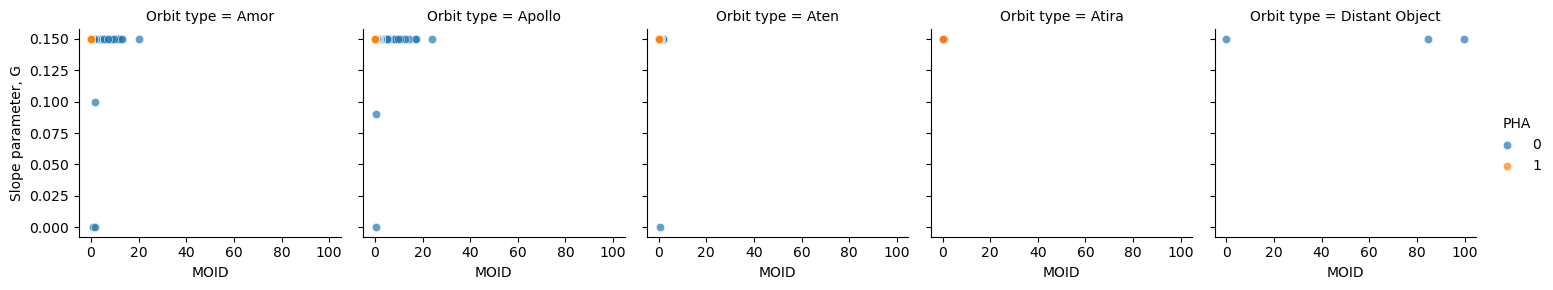

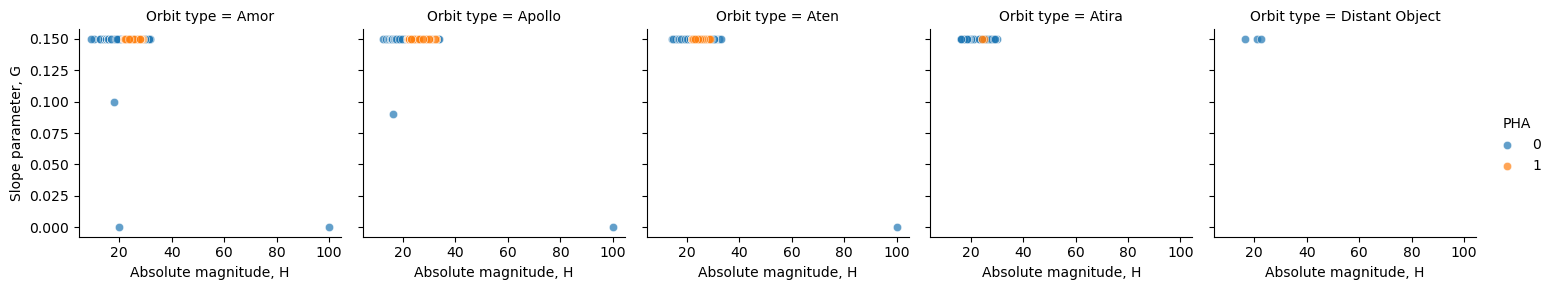

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


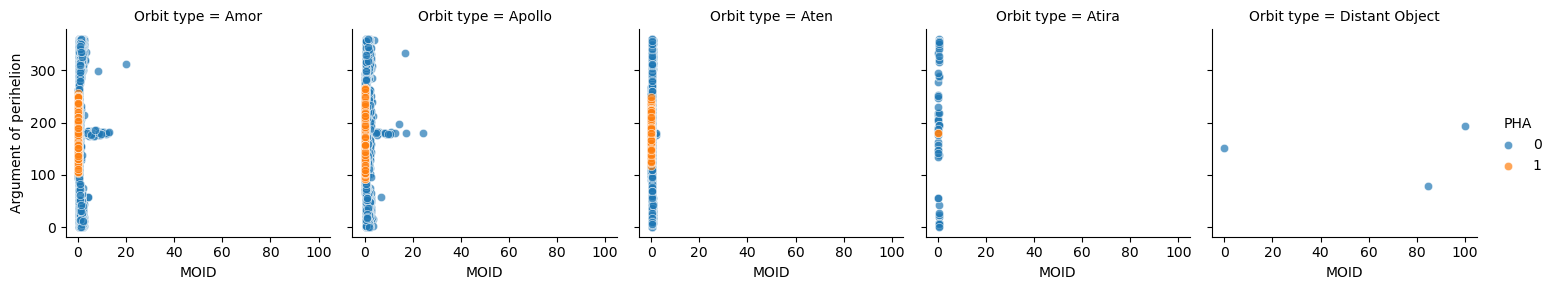

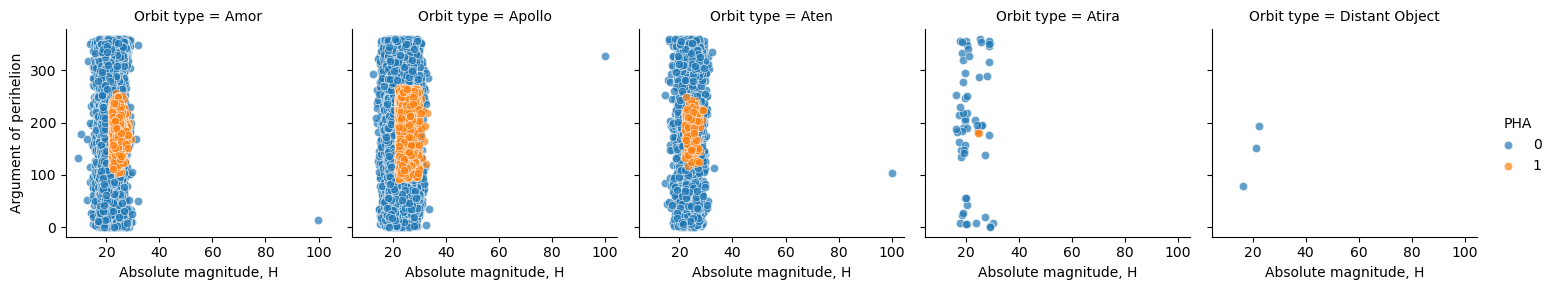

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


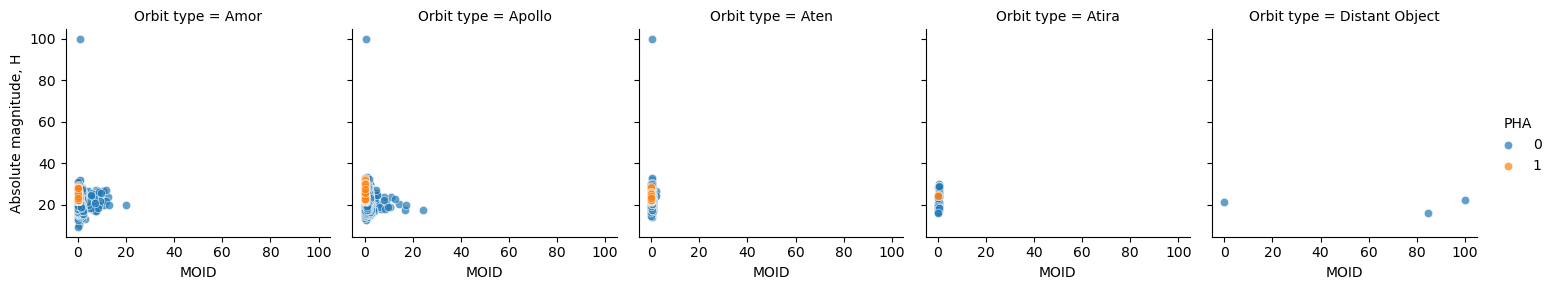

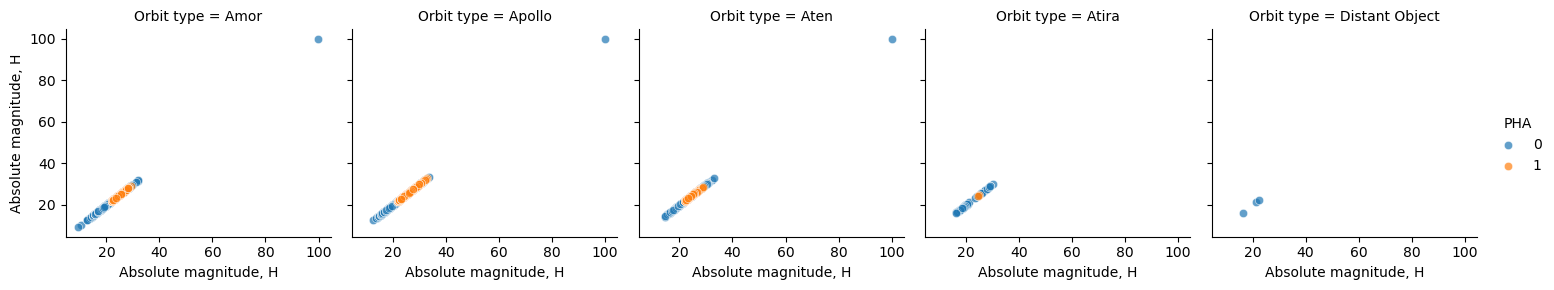

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


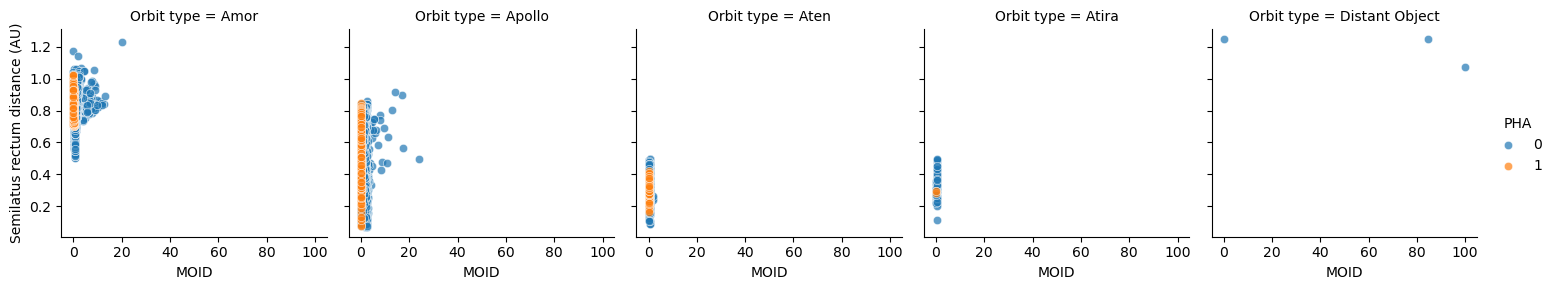

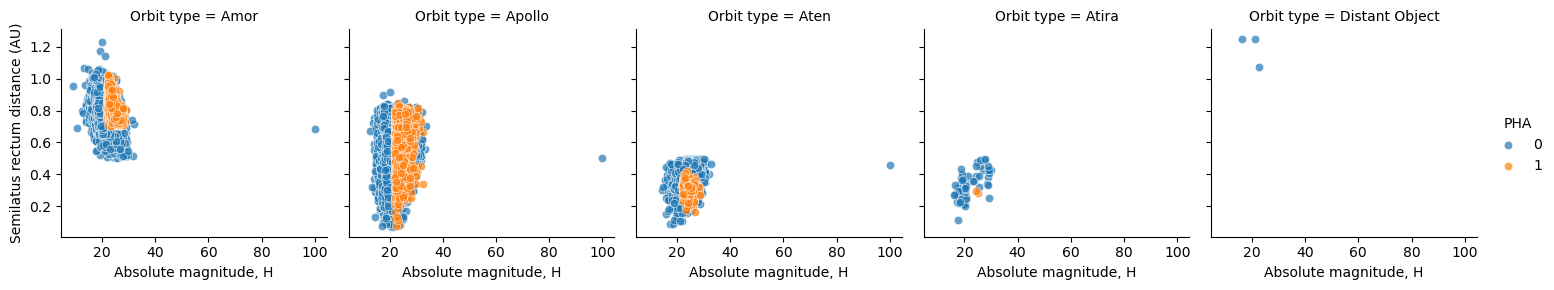

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


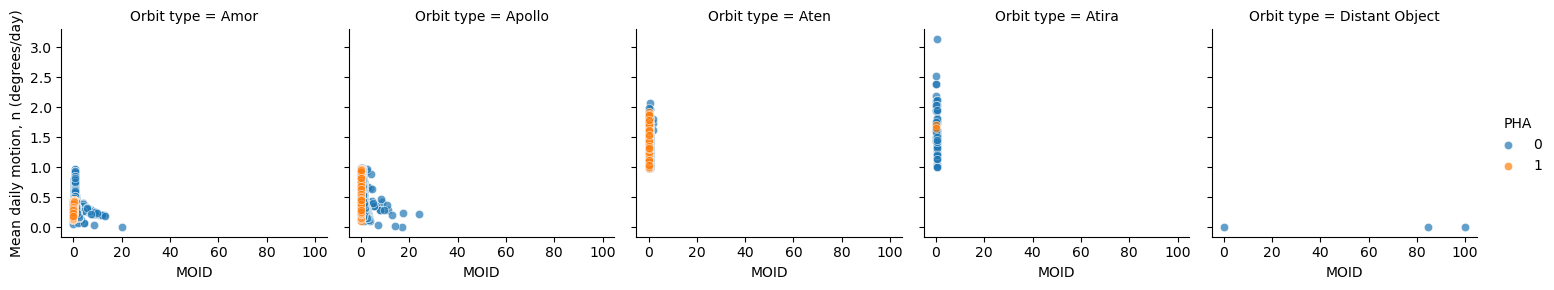

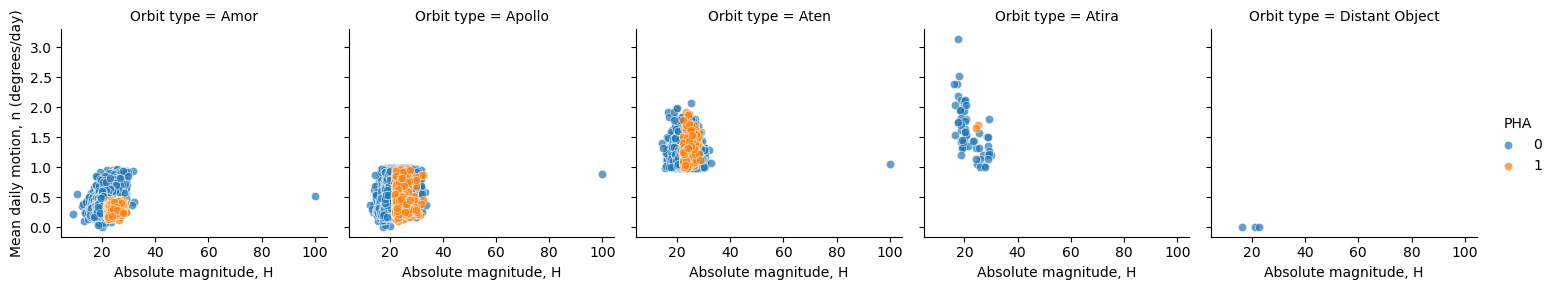

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


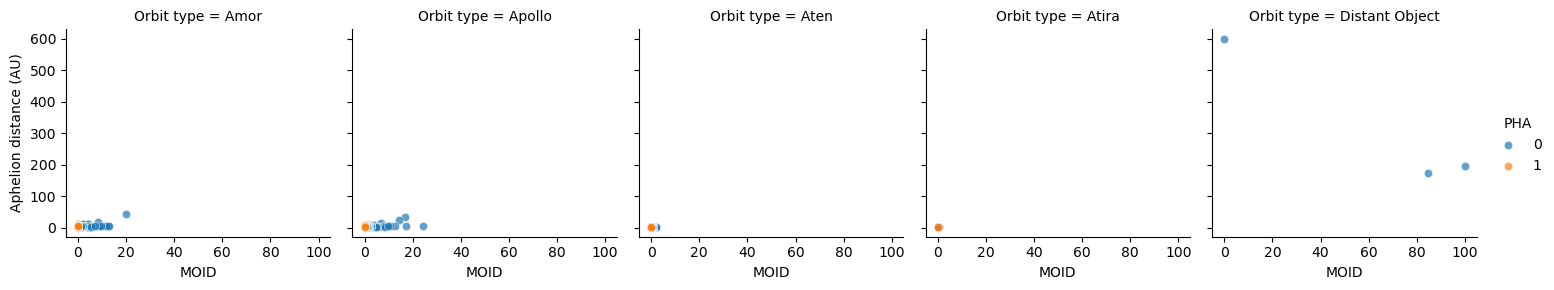

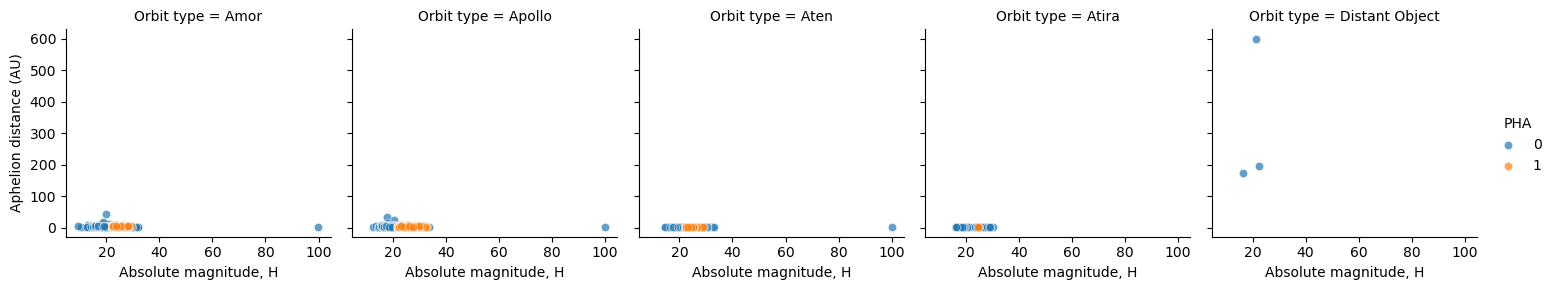

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


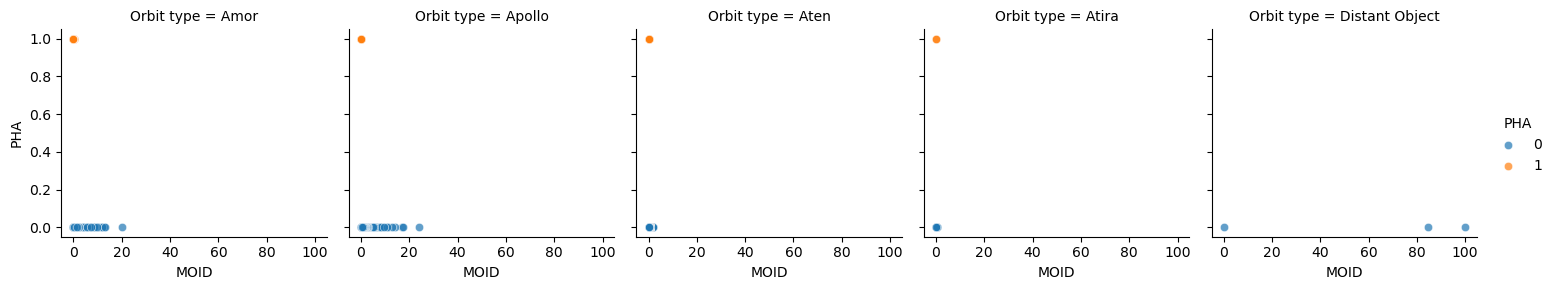

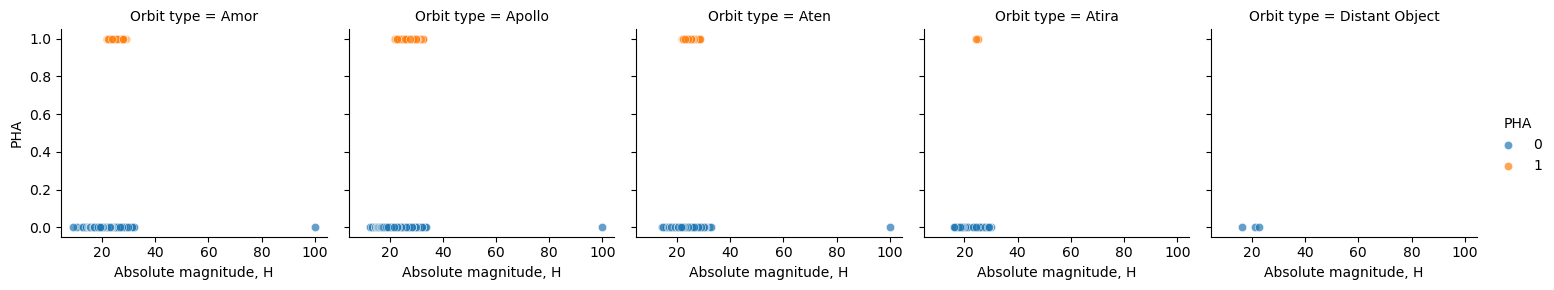

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


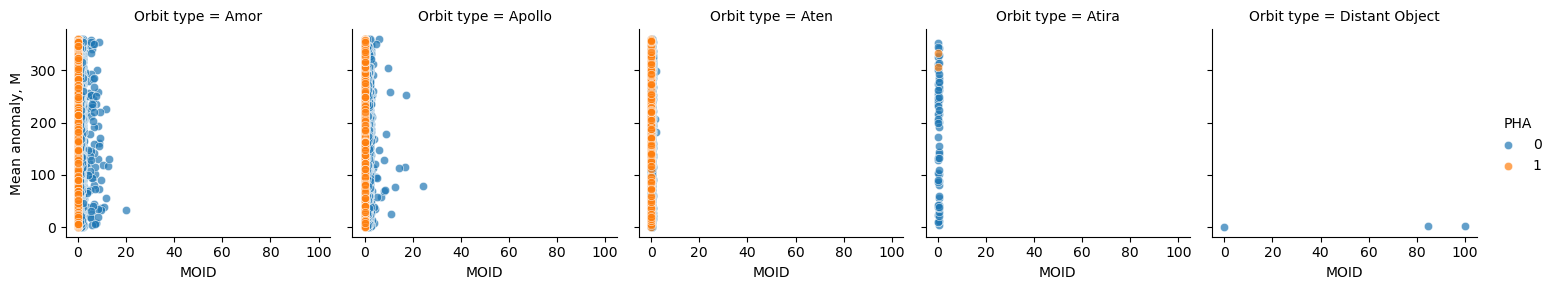

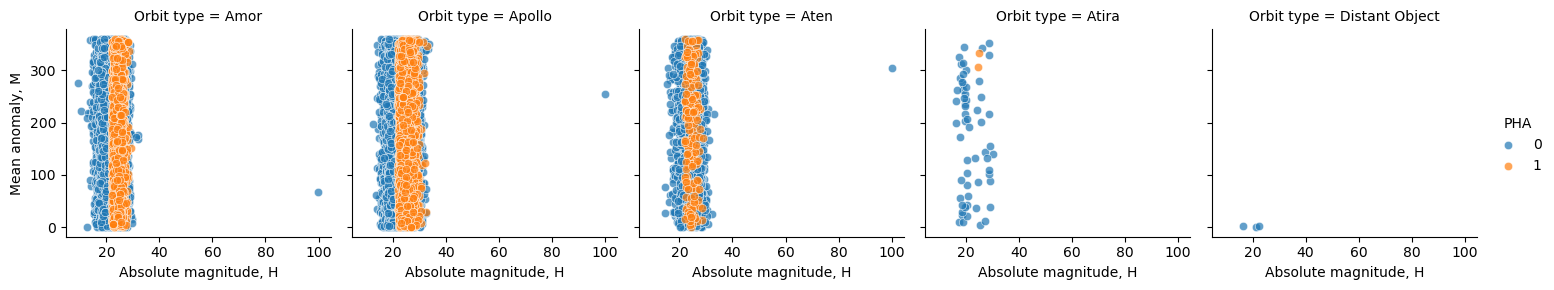

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


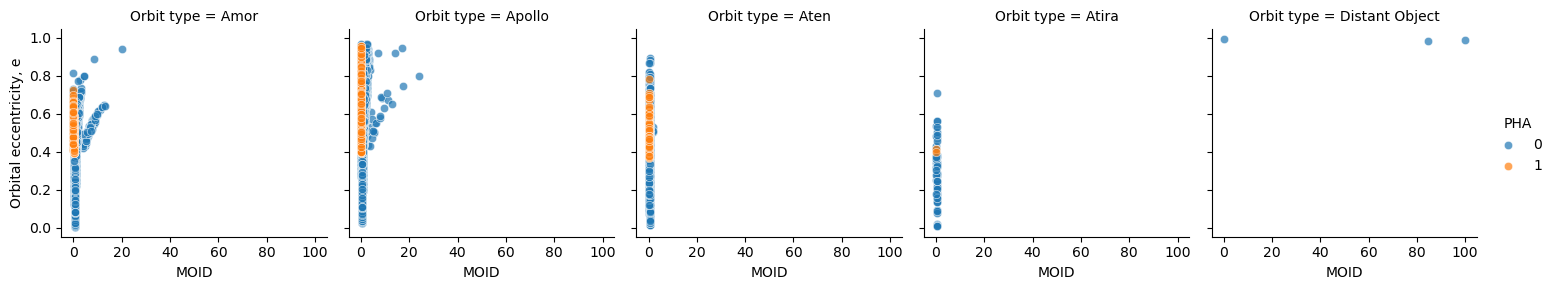

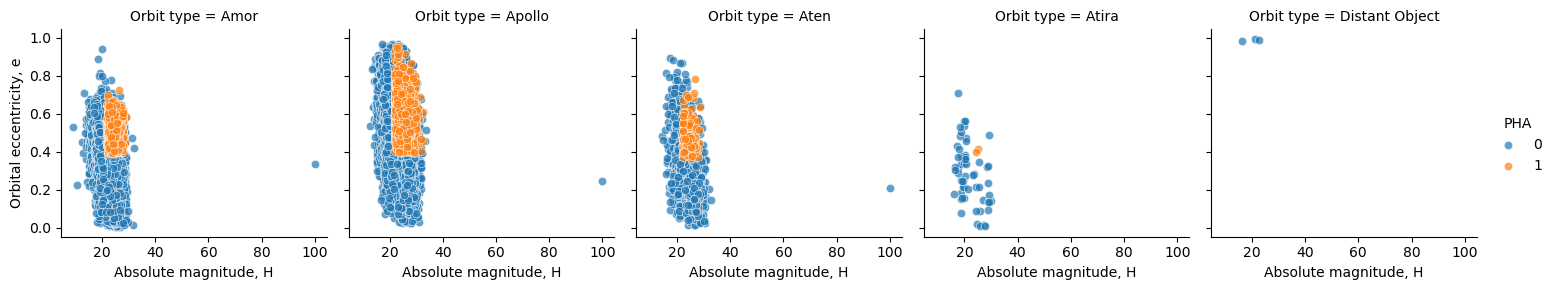

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


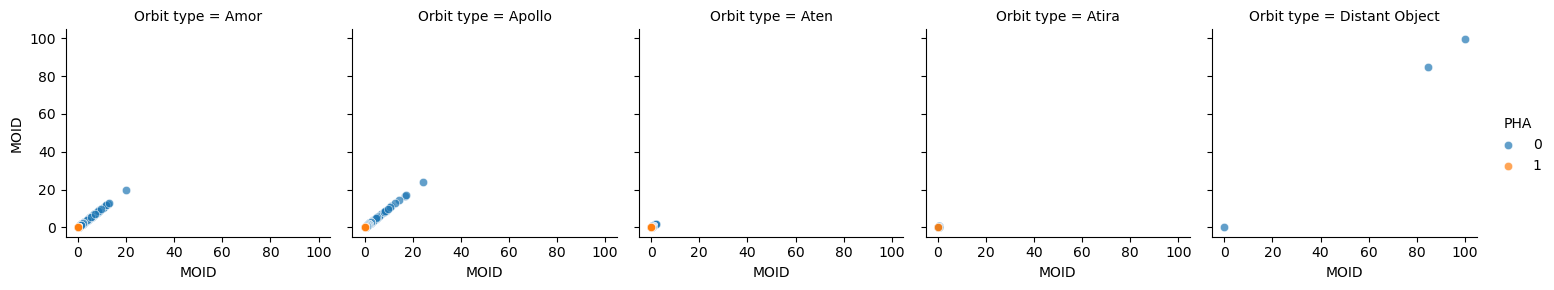

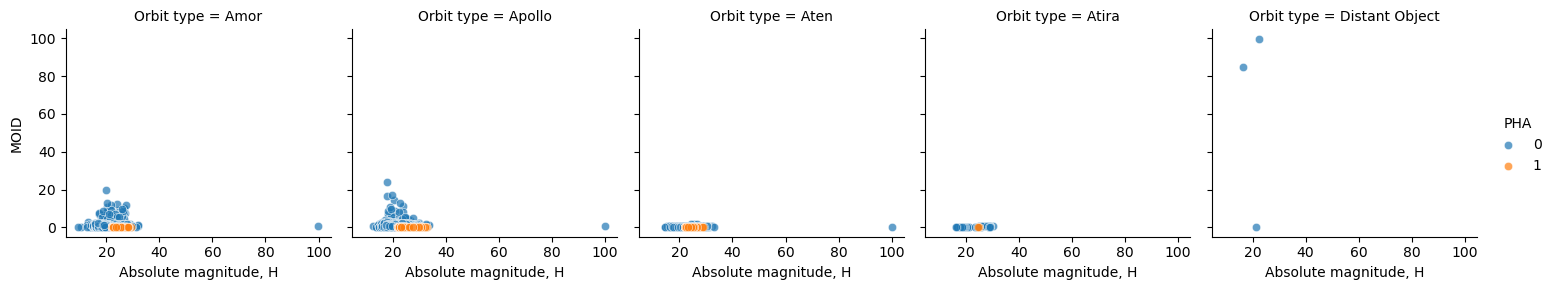

In [90]:
plot_scatter(new_data, imp_parameters)

In [91]:
other_parameters = ['r.m.s. residual (")', 'Other designations', 'Tp', 'Orbit type', 'NEO flag', 'One km NEO flag', 'Epoch of the orbit (Julian Date)', 'Node', 'Name', 'Perturbers 2', 'Number of oppositions', 'Perturbers', 'Orbital period (years)', 'Number of observations', 'Arc years', 'Semimajor axis, a (AU)', 'Inclination to the ecliptic', 'Perihelion distance (AU)', 'Number', 'Hex flags', 'Computer', 'Synodic period (years)', 'Principal designation']

In [92]:
new_data[other_parameters].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33351 entries, 0 to 33350
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   r.m.s. residual (")               33351 non-null  float64
 1   Other designations                551 non-null    object 
 2   Tp                                33351 non-null  float64
 3   Orbit type                        33351 non-null  object 
 4   NEO flag                          33351 non-null  int64  
 5   One km NEO flag                   33351 non-null  int64  
 6   Epoch of the orbit (Julian Date)  33351 non-null  float64
 7   Node                              33351 non-null  float64
 8   Name                              170 non-null    object 
 9   Perturbers 2                      33294 non-null  object 
 10  Number of oppositions             33351 non-null  int64  
 11  Perturbers                        33294 non-null  object 
 12  Orbi

In [93]:
new_data[other_parameters].describe()

,"r.m.s. residual ("")",Tp,NEO flag,One km NEO flag,Epoch of the orbit (Julian Date),Node,Number of oppositions,Orbital period (years),Number of observations,"Semimajor axis, a (AU)",Inclination to the ecliptic,Perihelion distance (AU),Synodic period (years)
count,33351.000000,3.335100e+04,33351.0,33351.000000,3.335100e+04,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000,33351.000000
mean,0.528970,2.460185e+06,1.0,0.041258,2.460194e+06,172.130514,2.097748,2.614310,111.616293,1.763143,12.055180,0.915156,5.642162
std,0.227248,3.315028e+02,0.0,0.198890,1.723436e+02,103.742514,2.848863,29.407373,348.987739,1.874873,10.722200,0.225452,205.643621
min,0.010000,2.451481e+06,1.0,0.000000,2.451840e+06,0.002790,1.000000,0.313730,4.000000,0.461711,0.006070,0.070462,0.457152
25%,0.350000,2.460016e+06,1.0,0.000000,2.460200e+06,80.881120,1.000000,1.476740,25.000000,1.296789,4.436955,0.791967,1.450778
50%,0.500000,2.460193e+06,1.0,0.000000,2.460200e+06,171.942990,1.000000,2.208424,43.000000,1.695853,8.516420,0.963396,1.815976
75%,0.700000,2.460367e+06,1.0,0.000000,2.460200e+06,252.633190,2.000000,3.209517,86.000000,2.175838,16.911535,1.061488,2.927335
max,4.390000,2.461463e+06,1.0,1.000000,2.460200e+06,359.965340,61.000000,5215.996722,14163.000000,300.763322,165.569480,1.299984,37244.781193


## Visualizations

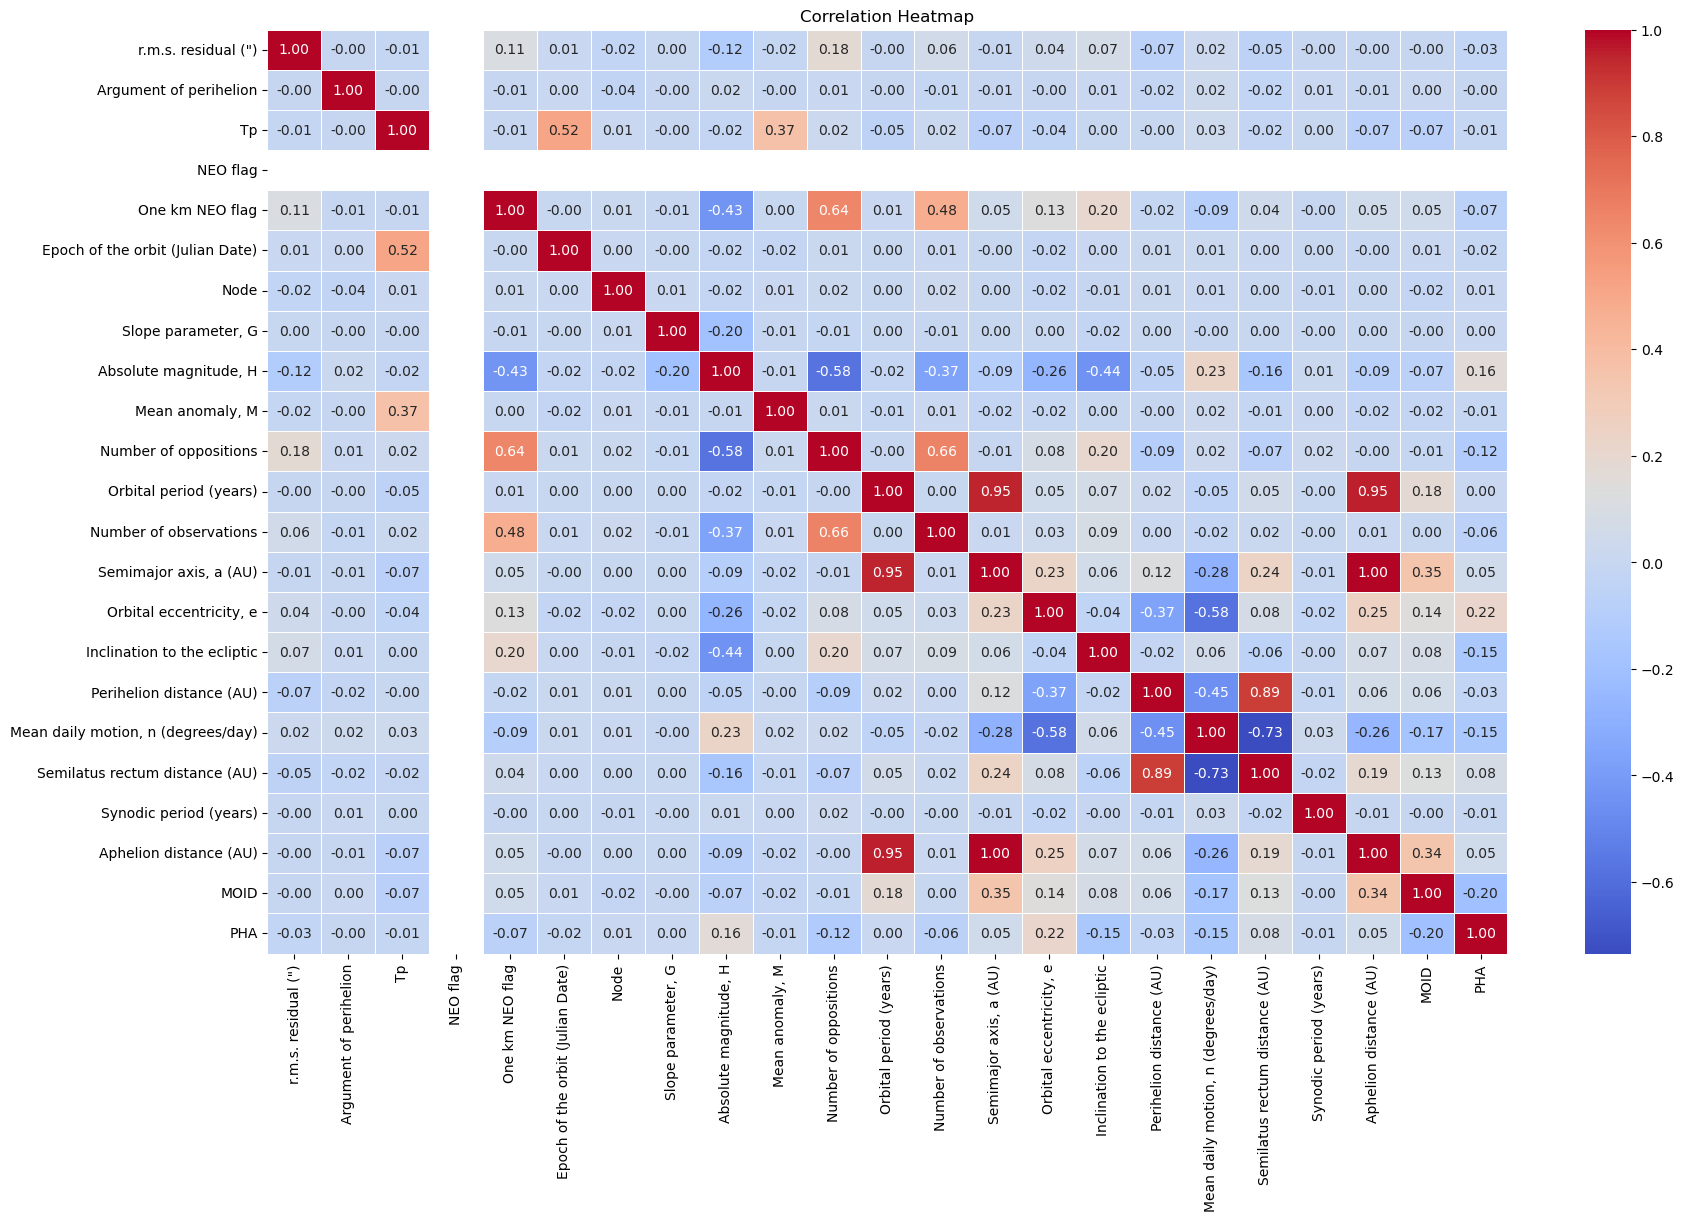

In [94]:
data_type_to_drop = 'object'
columns_to_drop = new_data.select_dtypes(include=[data_type_to_drop]).columns
heatmap_data = new_data.drop(columns=columns_to_drop)
heatmap_data = heatmap_data.drop(columns='Unnamed: 0')

correlation_matrix = heatmap_data.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

<Axes: xlabel='PHA', ylabel='Absolute magnitude, H'>

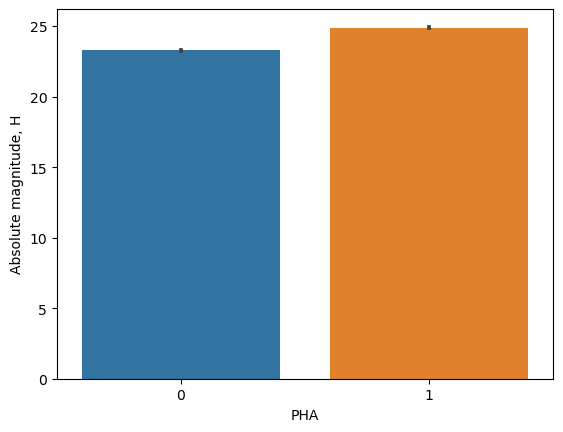

In [95]:
sns.barplot(data=new_data, x="PHA", y="Absolute magnitude, H")

<Axes: xlabel='MOID', ylabel='Absolute magnitude, H'>

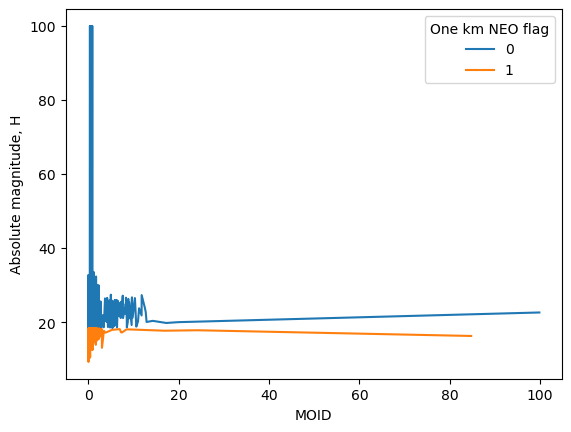

In [96]:
sns.lineplot(data = new_data, x = "MOID", y = "Absolute magnitude, H", hue = "One km NEO flag")

C:\Users\Tanay\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 25.0)

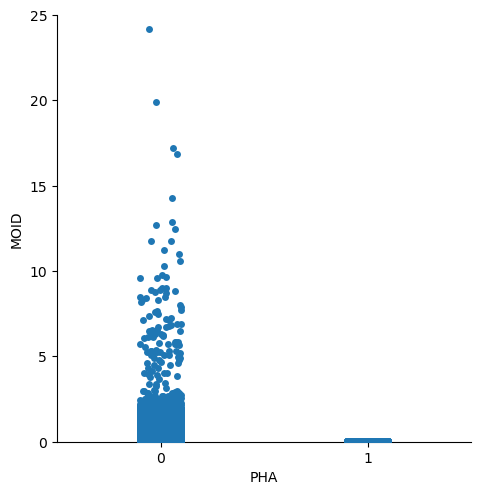

In [97]:
sns.catplot(data = new_data, y = "MOID", x = "PHA")
plt.gca().set_ylim([0, 25])

## Model Selection and Analysis

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


In [99]:
def model_fit_score(models, df):
    X = df.drop('PHA', axis=1)
    y = df['PHA']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    np.random.seed(42)
    model_scores = {}

    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(accuracy_score))
        model_scores[name] = np.mean(scores)

    model_scores = pd.DataFrame(model_scores, index=['Score']).transpose()
    model_scores = model_scores.sort_values('Score', ascending=False)
    return model_scores

In [100]:
new_data = new_data.fillna(0)

In [101]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [102]:
def random_forest_classifier(data_frame):
    X = data_frame.drop('PHA', axis=1)
    y = data_frame['PHA']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=10000)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    result = [accuracy, confusion_mat, classification_rep]
    return result

In [103]:
result_params_imp = random_forest_classifier(new_data[imp_parameters])
print("Accuracy:", result_params_imp[0], '\n')
print("Confusion Matrix:\n", result_params_imp[1], '\n')
print("Classification Report:\n", result_params_imp[-1], '\n')

Accuracy: 1.0 

Confusion Matrix:
 [[5994    0]
 [   0  677]] 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5994
           1       1.00      1.00      1.00       677

    accuracy                           1.00      6671
   macro avg       1.00      1.00      1.00      6671
weighted avg       1.00      1.00      1.00      6671
 



## Feature Important Analysis

In [104]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

In [105]:
def plot_feature_importance(data_frame):
    X = data_frame.drop('PHA', axis=1)
    y = data_frame['PHA']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    
    plt.title('Feature Importance')
    plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
    plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()

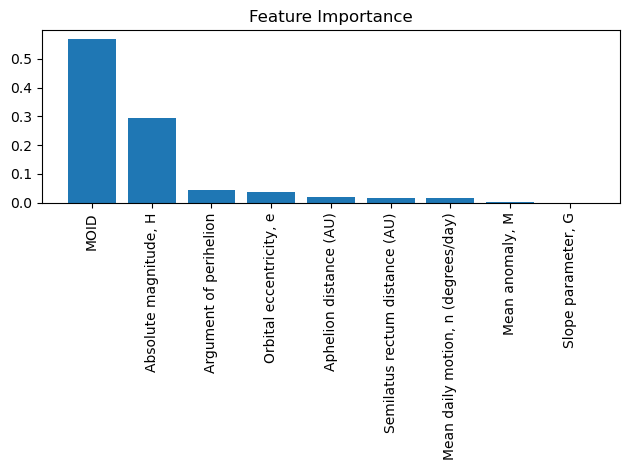

In [106]:
plot_feature_importance(new_data[imp_parameters])

## Gradient Boosting Classifier Model

In [107]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier

In [108]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
X = new_data[imp_parameters].drop('PHA', axis=1)
y = new_data[imp_parameters]['PHA']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)
    
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))

Learning rate:  0.05
Accuracy score (training): 0.898
Accuracy score (validation): 0.899
Learning rate:  0.075
Accuracy score (training): 0.898
Accuracy score (validation): 0.899
Learning rate:  0.1
Accuracy score (training): 0.898
Accuracy score (validation): 0.899
Learning rate:  0.25
Accuracy score (training): 0.993
Accuracy score (validation): 0.991
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 1.000


In [109]:
def gradient_boosting_classifier(data_frame):
    X = data_frame.drop('PHA', axis=1)
    y = data_frame['PHA']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    result = [accuracy, confusion_mat, classification_rep]
    return result

In [110]:
result_params_imp = gradient_boosting_classifier(new_data[imp_parameters])
print("Accuracy:", result_params_imp[0], '\n')
print("Confusion Matrix:\n", result_params_imp[1], '\n')
print("Classification Report:\n", result_params_imp[-1], '\n')

Accuracy: 0.9997001948733323 

Confusion Matrix:
 [[5994    0]
 [   2  675]] 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5994
           1       1.00      1.00      1.00       677

    accuracy                           1.00      6671
   macro avg       1.00      1.00      1.00      6671
weighted avg       1.00      1.00      1.00      6671
 



## SVC Model

In [111]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [112]:
def linear_svc_classifier(data_frame):
    X = data_frame.drop('PHA', axis=1)
    y = data_frame['PHA']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    classifier = SVC(kernel='linear', random_state=0)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    result = [accuracy, confusion_mat, classification_rep]
    return result

In [113]:
def rbf_svc_classifier(data_frame):
    X = data_frame.drop('PHA', axis=1)
    y = data_frame['PHA']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    classifier = SVC(kernel='rbf', random_state=0, gamma=0.01, C=1)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    result = [accuracy, confusion_mat, classification_rep]
    return result

In [114]:
result_params_imp = linear_svc_classifier(new_data[imp_parameters])
svc_lin_accuracy = result_params_imp[0]
print("Accuracy:", result_params_imp[0], '\n')
print("Confusion Matrix:\n", result_params_imp[1], '\n')
print("Classification Report:\n", result_params_imp[-1], '\n')

Accuracy: 0.9830610103432769 

Confusion Matrix:
 [[5935   59]
 [  54  623]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5994
           1       0.91      0.92      0.92       677

    accuracy                           0.98      6671
   macro avg       0.95      0.96      0.95      6671
weighted avg       0.98      0.98      0.98      6671
 



In [115]:
result_params_imp = rbf_svc_classifier(new_data[imp_parameters])
svc_rbf_accuracy = result_params_imp[0]
print("Accuracy:", result_params_imp[0], '\n')
print("Confusion Matrix:\n", result_params_imp[1], '\n')
print("Classification Report:\n", result_params_imp[-1], '\n')

Accuracy: 0.903912456903013 

Confusion Matrix:
 [[5968   26]
 [ 615   62]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      5994
           1       0.70      0.09      0.16       677

    accuracy                           0.90      6671
   macro avg       0.81      0.54      0.56      6671
weighted avg       0.89      0.90      0.87      6671
 



## Logistic Regression Model

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [117]:
def logistic_regression_model(data_frame):
    X = data_frame.drop('PHA', axis=1)
    y = data_frame['PHA']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    
    accuracy = logreg.score(X_test, y_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    result = [accuracy, confusion_mat, classification_rep]
    return result

In [118]:
result_params_imp = logistic_regression_model(new_data[imp_parameters])
print("Accuracy:", result_params_imp[0], '\n')
print("Confusion Matrix:\n", result_params_imp[1], '\n')
print("Classification Report:\n", result_params_imp[-1], '\n')

Accuracy: 0.9832109129066107 

Confusion Matrix:
 [[5957   43]
 [  69  602]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6000
           1       0.93      0.90      0.91       671

    accuracy                           0.98      6671
   macro avg       0.96      0.95      0.95      6671
weighted avg       0.98      0.98      0.98      6671
 



C:\Users\Tanay\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## ANN

In [119]:
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

In [120]:
def setup_and_train_ann(data_frame):
    X = data_frame.drop('PHA', axis=1)
    y = data_frame['PHA']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = Sequential()
    model.add(Dense(12, input_dim=9, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=25, batch_size=16)
    
    _, accuracy = model.evaluate(X_test, y_test)
    
    print()
    print('Accuracy of test: %.2f' % (accuracy * 100))
    
    return accuracy * 100

In [121]:
ann_accuracy = setup_and_train_ann(new_data[imp_parameters])

Epoch 1/25
1668/1668 [==============================] - 6s 3ms/step - loss: 0.3005 - accuracy: 0.8964
Epoch 2/25
1668/1668 [==============================] - 5s 3ms/step - loss: 0.2351 - accuracy: 0.8980
Epoch 3/25
1668/1668 [==============================] - 5s 3ms/step - loss: 0.1999 - accuracy: 0.9076
Epoch 4/25
1668/1668 [==============================] - 5s 3ms/step - loss: 0.1717 - accuracy: 0.9202
Epoch 5/25
1668/1668 [==============================] - 5s 3ms/step - loss: 0.1489 - accuracy: 0.9311
Epoch 6/25
1668/1668 [==============================] - 5s 3ms/step - loss: 0.1315 - accuracy: 0.9402
Epoch 7/25
1668/1668 [==============================] - 5s 3ms/step - loss: 0.1157 - accuracy: 0.9475
Epoch 8/25
1668/1668 [==============================] - 5s 3ms/step - loss: 0.1022 - accuracy: 0.9556
Epoch 9/25
1668/1668 [==============================] - 5s 3ms/step - loss: 0.0951 - accuracy: 0.9594
Epoch 10/25
1668/1668 [==============================] - 4s 3ms/step - loss: 0.086

In [122]:
models = {'RandomForestClassifier': RandomForestClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'SVC': SVC(),
          'LogisticRegression': LogisticRegression(max_iter = 10000)
         }

In [123]:
scores_for_models = model_fit_score(models, new_data[imp_parameters])
sorted_model_scores = scores_for_models.sort_values('Score', ascending=False)

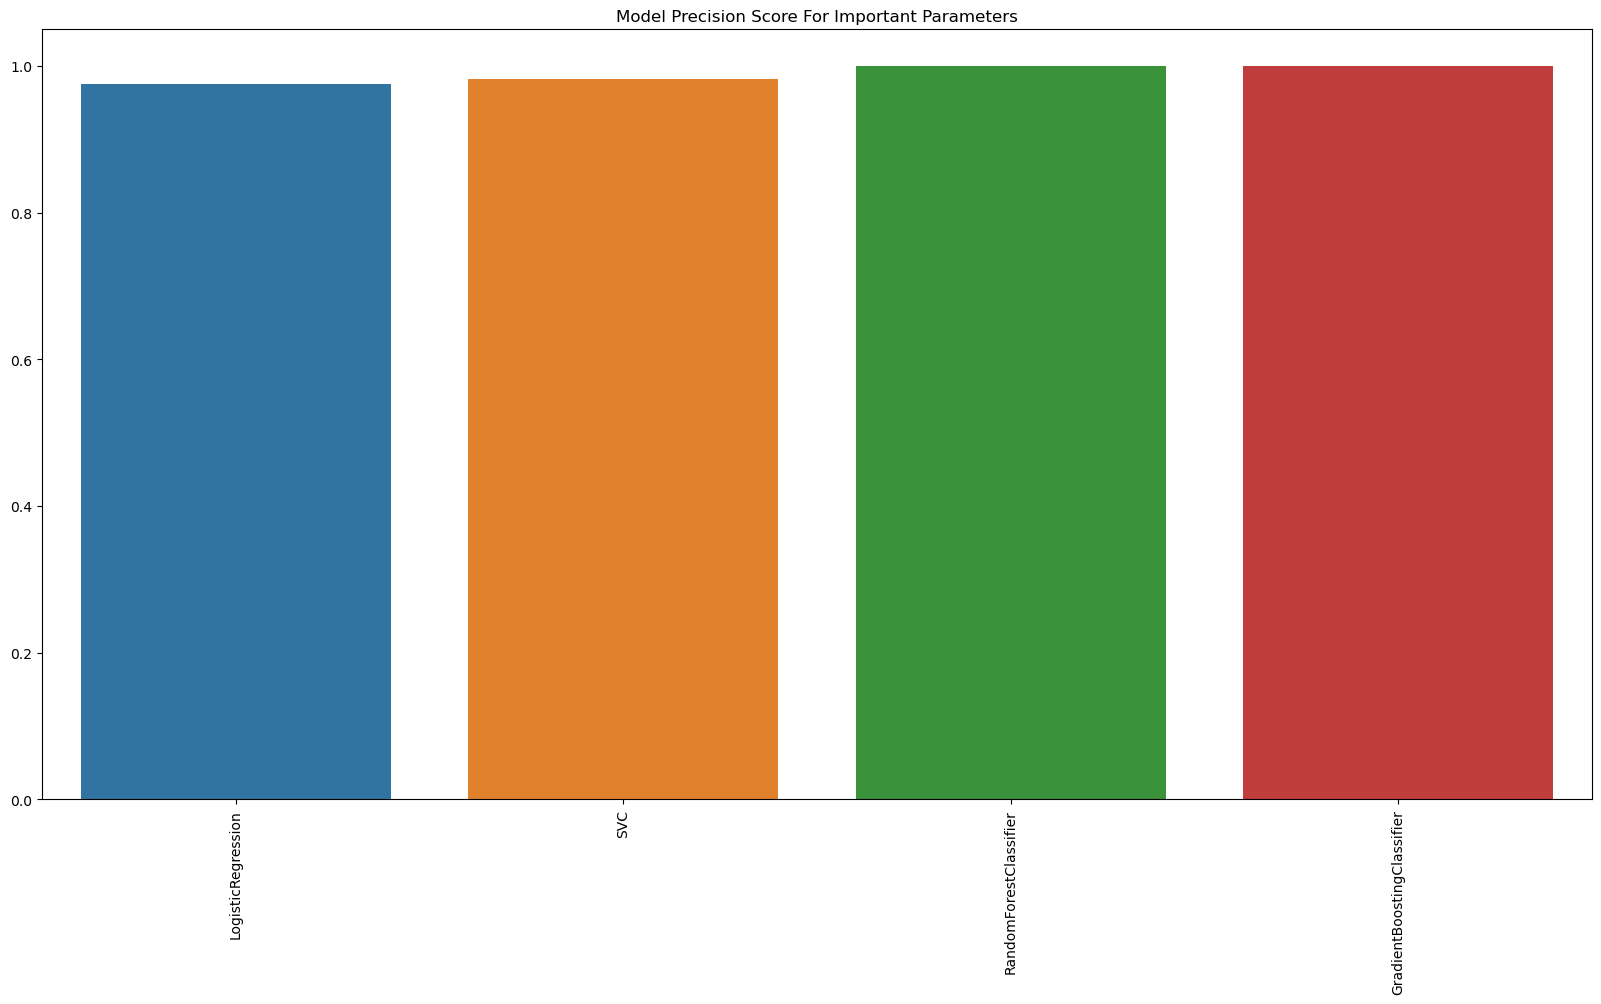

In [124]:
plt.figure(figsize=(20, 10))
sns.barplot(data=scores_for_models.sort_values('Score').T)
plt.title('Model Precision Score For Important Parameters')
plt.xticks(rotation=90)
plt.show()